# Mean Field Crowding Model

When using the model, please cite the following papers:
* Sapir, L.; Harries, D. Macromolecular Stabilization by Excluded Cosolutes: Mean Field
Theory of Crowded Solutions. Journal of Chemical Theory and Computation 2015, 11,
3478–3490.
* Not always sticky: Specificity of Protein Stabilization by Sugars is Conferred by Protein-Water Hydrogen Bonds
* Stewart, C. J.; Olgenblum, G.; Harries, D.; Pielak, G. J. Unraveling the enthalpy of
macromolecular crowding. Biophysical Journal 2023, 122, 336a.

## Table of content

1. [Motivation](#Motivation)
2. [Model Description](#Model-Description)
3. [Detailed Example (AQ16 with Glucose)](#Detailed-Example)
   1. [Cosolute Object - Flory-Huggins parameters](#Cosolute-Object-\--Flory\-Huggins-parameters)
   2. [Protein Object - Protien Domain Parameters](#Protein-Object-\--Protien-Domain-Parameters)
   3. [Crowding Object - Solving the Equilibrium Condition](#Crowding-Object-\--Solving-the-Equilibrium-Condition)
   4. [Fits to Folding Experiments](#Fits-to-Folding-Experiments)
5. [Review - Short Example (MET16 with Trehalose)](#Review-\--Short-Example)
6. [Bootstrapping - Error Estimation](#Bootstrapping-\--Error-Estimation)

## Motivation
Many biological lifeforms produce and accumulate solutes or cosolutes, which modify their protein stability in response to external stressors such desiccation, salinity, and significant temperature fluctuations. 
Many models have been developed to predict and explain how highly concetrated cosolutes, also termed crowders, modulate the protein stability.
The most notable models are the Asakura and Oosawa model (AOM) and scaled particle theory (SPT) that use protein-cosolute  hard core or excluded volume interactions to explain the increase in protein stabilization in presence of stabilizng cosolutes or crowders.

Howerver, excluded volume alone cannot fully explain the experimentaly determined folding free energy of many proteins versus cosolutes concetration.
Even worse, excluded volume alone does not account at all for the experimentaly determined enthalpy and entropy that contain infromation on the underlying folding mechansim.
We have therefore developed a mean-field model for protein crowding that in addition to excluded volume interactions also take into account two additional important interactions: cosolute-solvent non-ideal mixing and protein-cosolute soft (i.e., non hard core) interactions.  

## Model Description
In this section we describe in short the mean-field model and its implementation to give a basic understanding that is needed to fit and analyze folding experiments in presence of crowders.
Each of the papers listed above provides detailed descriptions of the model.

Our mean-field model for crowding is based on the Flory-Huggins (FH) model for binary mixtures. In the FH model, the interactions between a cosolute and a solvent (water) are described by two interactions, each with its own parameter:
1. Excluded volume interactions, $\nu$.
2. Non-ideal mixing interactions, $\chi$.
 
The hard core interactions described by $\nu$ are purly entropic, while the non-ideal mixing is composed of an enthalpic and entropic contributions, $\chi=\chi_H-\chi_{TS}$. 
These two paramters are determined from measurments in binary mixtures (without protein) and used to describe the mixture mixing free energy, enthalpy, entropy, and chemical potentials.

We extend the FH model to trenary mixture (protein, cosolute, and solvent) by deviding the mixture into two distinct domains:
1. The protein domain - the volume near the protein surface that is buried in the folding process.
2. The bulk domain - the volume that is unperturbed by the protein presence.
 
The protein domain volume is defined by two parameter: the change in surface accessible surface area upon folding $\Delta SASA$ and a length scale set by the cosolute dimention, $a=\nu^{1/3}$.
Moreover, the mixing free energy in the protein domain is modified to account for the smaller mixing volume near the protein surface and the soft interactions between the protein and cosolute.
The soft interactions are depicted by a single free energy parameter that is composed of an entropic and enthalpic contributions, $\varepsilon=\varepsilon_H-\varepsilon_{TS}$.
$\varepsilon$ is the only fitting parameter for the folding free energy versus concetration and $\varepsilon_{TS}$ is the only fitting parameter for the enthalpy and entropy versus concetration. 
Importantly, $\nu$ and $\chi=\chi_H-\chi_{TS}$ are determined independantly and are used as determined from measurments of binary mixtures. 

To get insight on the thermodynamics of the folding mechansim for a protein-cosolute pair the experimental folding free energy, enthalpy, and entropy are fitted by our mean field model. 
The fits result in the contributions of the excluded volume, non-ideal mixing, and soft interactions to the folding process. 


## Detailed Example
In the following, we give a detailed example on how to deploy our mean-field model to fit and analyze folding experiment. We demonstrate the fitting procedure on the folding free energy, enthalpy, and entropy of the small protein AQ16 in presence of the sugar D-glucose. 
To make the example practical and insightful, the each step of the analysis is devided into two section: <span style="color:blue"> *theory* </span> and <span style="color:red"> *implementation*</span>.


First, we import needed libraries and our crowding model:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FH_crowding import Cosol, Protein ,crowding_model

### Cosolute Object - Flory-Huggins parameters

#### <span style="color:blue"> *Theory*</span>
The information on the cosolute is given by it's unique FH paramters:
1. Excluded volume interactions, $\nu$.
2. Non-ideal mixing interactions, $\chi$.
3. The entropic non-ideal mixing contribution, $\chi_{TS}$.

$\nu$ is determined from fits to experimental molar volume versus cosolute concetration of the cosolute-solvent binary mixtures.
$\chi$ is determined from fits to experimental osmotic pressure versus cosolute concetration.
$\chi_{TS}$ is determined from the osmotic pressure temperature depedance.

The following is a table that contain the values of the FH parameters for several sugars and polyols that we have measured and published in the paper: <span style="color:orange"> *Not always sticky: Specificity of Protein Stabilization by Sugars is Conferred by Protein-Water Hydrogen Bonds*</span>

We will use the values for glucose in the following examples.

#### Table 1. FH paramters

Parameter | Glycerol | Glucose | Galactose | Sorbitol | Trehalose | Sucrose
--- | --- | --- | --- | --- | --- | ---
$\nu$ | 3.95 (0.01) | 6.27 (0.01) | 6.26 (0.01) | 6.71 (0.01) | 11.7 (0.01) | 11.9 (0.01)
$\chi$ | 0.233 (0.003) | 0.317 (0.009) | 0.35 (0.01) | 0.381 (0.001) | 0.433 (0.004) | 0.452 (0.001)
$\chi_H$ | -0.25 (0.03) | 0.000 (0.009) | -0.72 (0.09) | 0.09 (0.02) | -0.69 (0.09) | -0.40 (0.09)
$\chi_{TS}$ | -0.48 (0.03) | -0.317 (0.009) | -1.07 (0.09) | -0.29 (0.02) | -1.12 (0.09) | -0.854 (0.09)

cite:
<span style="color:orange"> *Not always sticky: Specificity of Protein Stabilization by Sugars is Conferred by Protein-Water Hydrogen Bonds*</span>

#### <span style="color:red"> *Implementation*</span>
The FH parameter are inserted into the model through a <span style="color:green"> ***cosolute***</span> object as follows:

cosol_object = Cosol($M_C$, $\nu$, $\chi$, $\chi_{TS}$, phiC_min=$min(\phi_C)$, phiC_max=$max(\phi_C)$, dphiC=$delta(\phi_C)$) 

where $M_C$ is the cosolute molar mass and $min(\phi_C)$, $max(\phi_C)$, and $delta(\phi_C)$) are the minimal, maximal, and step of the the cosolute volume fraction $\phi_C$.

The new cosol_object can be used to calculate basic thermodynamic potentials based on the FH model, which are useful for sanity check of the parameters. 

In the following we:
1. Generate a cosolute object for glucose.
2. Plot it's osmotic pressure against three different concetrations.
3. Plot the folding free energy, enthalpy, entropy, and chemical potential against the cosolute volume fraction. 

In [2]:
# 1. Generate a cosolute object for glucose.
gluc = Cosol(6.27, 0.317, -0.317)
print(str(gluc))

Cosol (ν=6.27, χ=0.317, χₛ=-0.317)


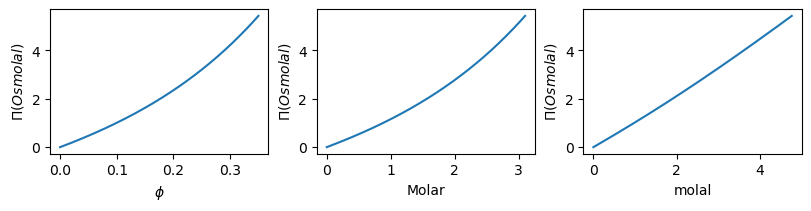

In [3]:
# 2. Plot the osmotic pressure against three different concetrations.
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 2), layout="constrained")
axes[0].plot(gluc.phiC,gluc.osm)
axes[0].set_xlabel(r'$\phi$')
axes[0].set_ylabel(r'$\Pi (Osmolal)$')
axes[1].plot(gluc.molar,gluc.osm)
axes[1].set_xlabel(r'Molar')
axes[1].set_ylabel(r'$\Pi (Osmolal)$')
axes[2].plot(gluc.molal,gluc.osm)
axes[2].set_xlabel(r'molal')
axes[2].set_ylabel(r'$\Pi (Osmolal)$')
plt.show()

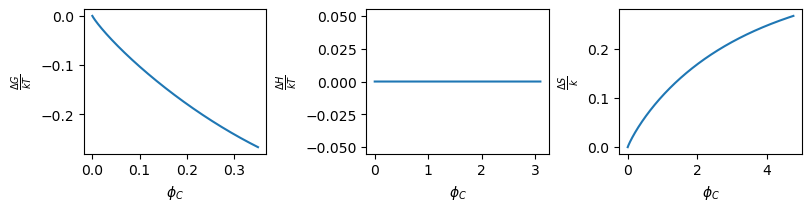

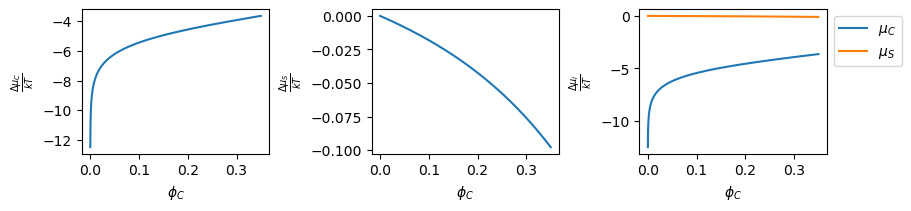

In [4]:
# 3. Plot the folding free energy, enthalpy, entropy, and chemical potential against the cosolute volume fraction.
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8, 2), layout="constrained")
axes[0].plot(gluc.phiC,gluc.dG)
axes[0].set_xlabel(r'$\phi_C$')
axes[0].set_ylabel(r'$\frac{\Delta G}{kT}$')
axes[1].plot(gluc.molar,gluc.dH)
axes[1].set_xlabel(r'$\phi_C$')
axes[1].set_ylabel(r'$\frac{\Delta H}{kT}}$')
axes[2].plot(gluc.molal,gluc.dS)
axes[2].set_xlabel(r'$\phi_C$')
axes[2].set_ylabel(r'$\frac{\Delta S}{k}$')

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 2), layout="constrained")
axes[0].plot(gluc.phiC,gluc.muC)
axes[0].set_xlabel(r'$\phi_C$')
axes[0].set_ylabel(r'$\frac{\Delta \mu_C}{kT}$')
axes[1].plot(gluc.phiC,gluc.muS)
axes[1].set_xlabel(r'$\phi_C$')
axes[1].set_ylabel(r'$\frac{\Delta \mu_S}{kT}}$')
axes[2].plot(gluc.phiC,gluc.muC,gluc.phiC,gluc.muS)
axes[2].set_xlabel(r'$\phi_C$')
axes[2].set_ylabel(r'$\frac{\Delta \mu_i}{kT}}$')
axes[2].legend(['$\mu_C$','$\mu_S$'],bbox_to_anchor=(1,1))
plt.show()

### Protein Object - Protien Domain Parameters

#### <span style="color:blue"> *Theory*</span>
For the protein only two parameters are needed for the model:
1. Protein domain area, defined by the change in solvent accessible surface area upon folding, $\Delta SASA$.
2. Protein domain thikness or extent into the solution, $a$

Since the protein domain thikness is set by the cosolute size, $a=\nu^{1/3}$, the only parameter needed for the protein object is $\Delta SASA$, which can be calculated from servers like [ProtSA](http://webapps.bifi.es/ProtSA/).

For AQ16, $\Delta SASA = 242.6 \overset{\circ}{\mathrm {A}}^2$

#### <span style="color:red"> *Implementation*</span>
The value of $\Delta SASA$ is inserted to the moldel through the <span style="color:green"> ***protein***</span> object as follows: 

protein_object = Protein($\Delta SASA$)

In [5]:
AQ16 = Protein(242.6) 
print(str(AQ16))

Protein (SASA=242.6)


### Crowding Object - Solving the Equilibrium Condition

Generally, we wish to use the model to resolve the contributions of $\nu$, $\chi$, and $\varepsilon$ to the folding free energy, enthalpy, and entropy derived from a folding experiment. 
This is achived by fitting the model with $\varepsilon$ and $\varepsilon_{TS}$ as a only variables together with the determined (and fixed) values of $\Delta SASA$, $\nu$, $\chi$, and $\chi_{TS}$ parameters to the experimental results.
However, the model can also be used to determine the contributions of $\nu$, $\chi$, $\varepsilon$, and thier entropic and enthalpic contributions for any value of $\varepsilon$ and $\varepsilon_{TS}$ we want to examine.
Here we will use the mean-field model to resolve the contributions of $\nu$, $\chi$, and $\varepsilon$ to the folding free energy, enthalpy, and entropy for a value of $\varepsilon$ of our choosing. 
Fits to an experimental results are discussed in the next section.

#### <span style="color:blue"> *Theory*</span>
To get $\Delta\Delta G_\nu$, $\Delta\Delta G_\chi$, and $\Delta\Delta G_\varepsilon$ we need to solve the following equilibrium condition:
$$
\nu\mu_S^\mathrm{bulk}-\mu_C^\mathrm{bulk}+\mu_C^\mathrm{surf}-\nu\mu_S^\mathrm{surf}=0
$$
where, $\mu_{S/C}^\mathrm{bulk}$ are the solvent and cosolute chemical potential in bulk and $\mu_{S/C}^\mathrm{surf}$ are the solvent and cosolute chemical potential in the protein domain.
Solving this equilibrium condition resolve the cosolute and solvent concentrations in the protein domain that are used to calculate the model folding free energies.
Then, the enthalpic and entropic contributions are calculated using the values of $\chi_{TS}$ and $\varepsilon_{TS}$.

#### <span style="color:red"> *Implementation*</span>
Once the cosolute and protien objects are initialized with the appropriate model values, a <span style="color:green"> ***Crowding***</span> object is initialized with four arguments:
1. Protein object
2. Cosolute object
3. Value of $\varepsilon$
4. Value of $\varepsilon_{TS}$

Crowding_object = crowding_model(protein_object, Cosolute_object, $\varepsilon$, $\varepsilon_{TS}$)

The model is then solved for the specific values of  $\varepsilon$ and $\varepsilon_{TS}$ by using the "solve_crowding()" method.
For convinience, the results can be plotted using the "plot_results()" method. 

In the following we:
1. Generate a Crowding object for AQ16 with glucose.
2. Use "solve_crowding()" to solve the equilibrium condition for a given $\varepsilon$ and $\varepsilon_{TS}$.
3. Use "plot_results()" to plot the following:
    1. Change in preferential hydration coefficient versus concetration.
    2. Osmotic pressure versus concetration.
    3. Volume fraction in the protein domain versus concetration.
    4. Contributions to the folding free energy versus concetration.
    5. Contributions to the folding enthalpy versus concetration.
    6. Contributions to the folding entropy versus concetration.
    7. Contributions to the folding free energy versus osmotic pressure.
    8. Enthalpy-entropy plot.
    9. Zoom in of the enthalpy-entropy plot.

In [6]:
# 1. Generate a Crowding object for AQ16 with glucose.
AQ16_gluc=crowding_model(AQ16,gluc, 0.01, -0.2)
print(str(AQ16_gluc))

Mean-Field Model:
Soft_Interactions (ε=0.01, εₛ=-0.2) 
Protein (SASA=242.6) 
Cosolute (ν=6.27, χ=0.317, χₛ=-0.317)


In [7]:
# 2. Use "solve_crowding()" to solve the equilibrium condition for a given soft interaction contribution
AQ16_gluc.solve_crowding()

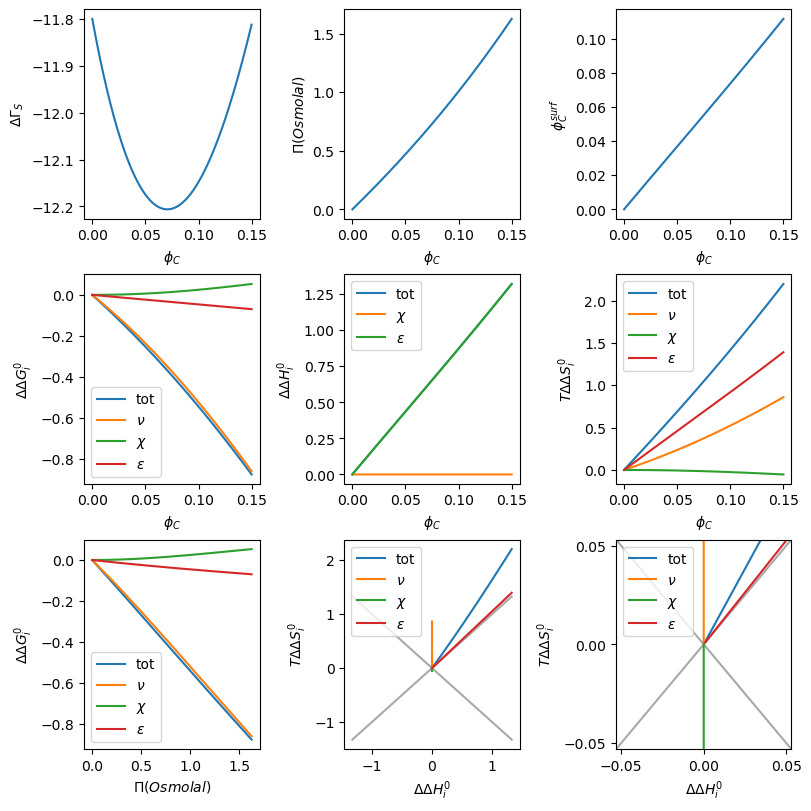

In [9]:
# 3. Plot results
AQ16_gluc.plot_results()

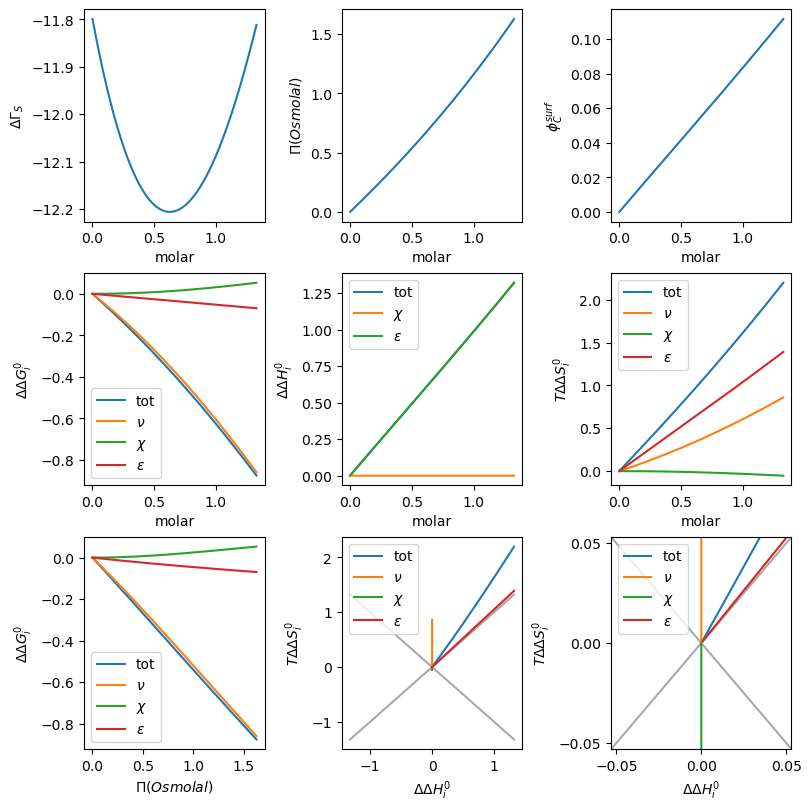

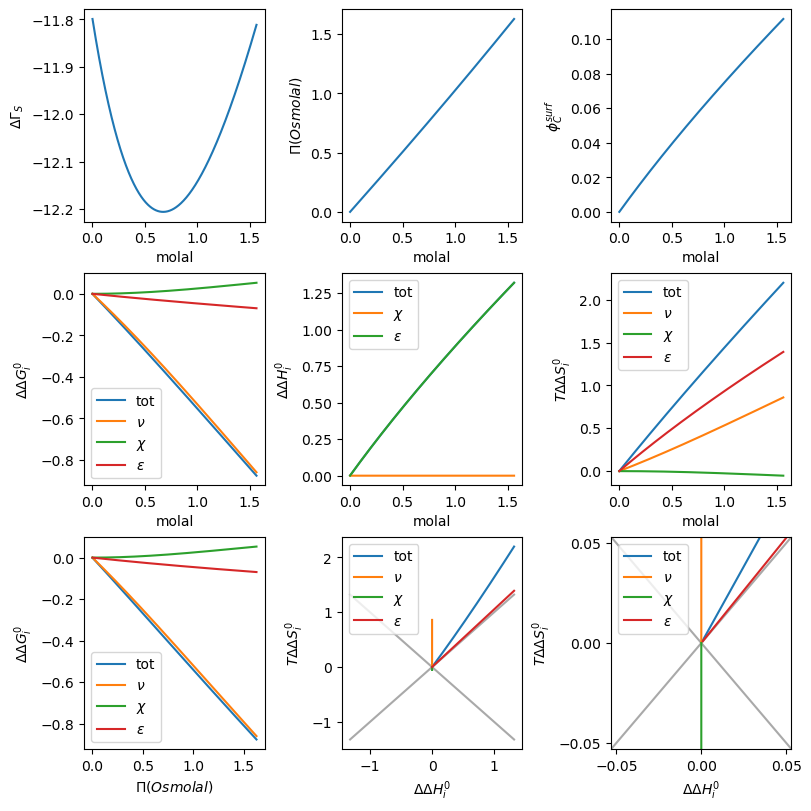

In [10]:
# We can also plot the results versus molar or molal concetrations:
AQ16_gluc.plot_results(concentration_type='molar')
AQ16_gluc.plot_results(concentration_type='molal')

### Fits to Folding Experiments

#### <span style="color:blue"> *Theory*</span>
To fit the model to experimentaly determined folding free energies versus cosolute concetration we solve the equilbrium condition and minimize the RMSD of the model from the experimental folding free energy with respect to $\varepsilon$.
Once $\varepsilon$ is determined, we repeat the process for the folding enthalpy and entropy with respect to $\varepsilon_{TS}$

#### <span style="color:red"> *Implementation*</span>

To fit the experimental free energy versus concetration we use:

crowding_object.fit_eps($c_{exp,G}$, $\Delta\Delta G_{exp}$, concentration_type='phi/molar/molal')

where $c_{exp,G}$ is the experimental concetration, $\Delta\Delta G_{exp}$ is the folding free energy (in kJ/mol), and  concentration_type is the type of concetration used in $c_{exp}$, either volume fraction, molar, or molal.

To fit the experimental enthalpy and entropy versus concetration we use:

crowding_object.fit_epsTS($c_{exp,HS}$, $\Delta\Delta H_{exp}$, $T\Delta\Delta S_{exp}$, concentration_type='phi/molar/molal')

where $c_{exp,HS}$ is the concetration and $\Delta\Delta H_{exp}$ and $T\Delta\Delta S_{exp}$ are the experimental folding enthalpy and entropy.

To add experimental data to the figure of "plot_results()" use the following flags:

crowding_object.plot_results(exp_conc=$c_{exp,G}$,exp_ddG=$\Delta\Delta G_{exp}$, exp_concT=$c_{exp,HS}$, exp_ddH=$\Delta\Delta H_{exp}$, exp_TddS=$T\Delta\Delta S_{exp}$)

In the following we:
1. Use the method "fit_eps" to fit the experimentaly dervied folding free energy of AQ16 versus glucose volume fraction.
2. Plot the results for $\varepsilon$, with experimental data in the plot.
3. Use the method "fit_epsTS" to fit the folding enthalpy and entropy of of AQ16 versus glucose volume fraction.
4. Plot the results for $\varepsilon_{TS}$, with experimental data in the plot.
5. Export the results to a csv file.

In [11]:
# Experimental data:
phi=[ 0.02079 ,0.03812, 0.05279, 0.06537, 0.07626, 0.0858, 0.09422,0.1017,0.10839]
ddG=[-0.10248,-0.05477,-0.13636,-0.18235,-0.227,-0.2616,-0.28996,-0.34702,-0.32477]

phiT=[0.0359,0.0693,0.1015]
ddH = [-0.49079,-0.68976,-1.21411]
TddS = [-0.32863,-0.45695,-0.84406]

In [12]:
# 1. fit free energy
AQ16_gluc.fit_eps(phi, ddG) 
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('The new soft intraction paramter is: {}'.format(AQ16_gluc.eps))
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')


Optimization terminated successfully.
         Current function value: 0.005965
         Iterations: 5
         Function evaluations: 16
         Gradient evaluations: 8
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
The new soft intraction paramter is: -0.03751570292632603
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


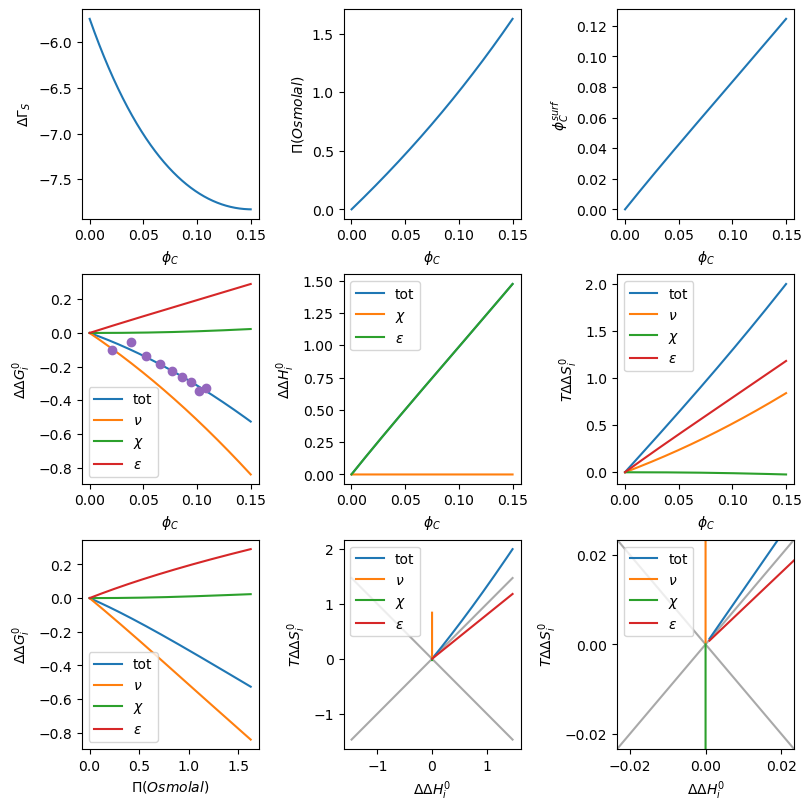

In [13]:
# 2. plot results of free energy fit
AQ16_gluc.plot_results(exp_conc=phi,exp_ddG=ddG)

In [14]:
# 3. fit enthalpy and entropy
AQ16_gluc.fit_epsTS(phiT, ddH, TddS, concentration_type='phi')
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('The soft intraction paramter is {} \nthe enthalpic contribution is {} \nand the entropic contributions is: {}'.format(AQ16_gluc.eps, AQ16_gluc.epsH, AQ16_gluc.epsTS))
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')


Optimization terminated successfully.
         Current function value: 0.037699
         Iterations: 1
         Function evaluations: 6
         Gradient evaluations: 3
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
The soft intraction paramter is -0.03751570292632603 
the enthalpic contribution is 0.21449632547695605 
and the entropic contributions is: 0.2520120284032821
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


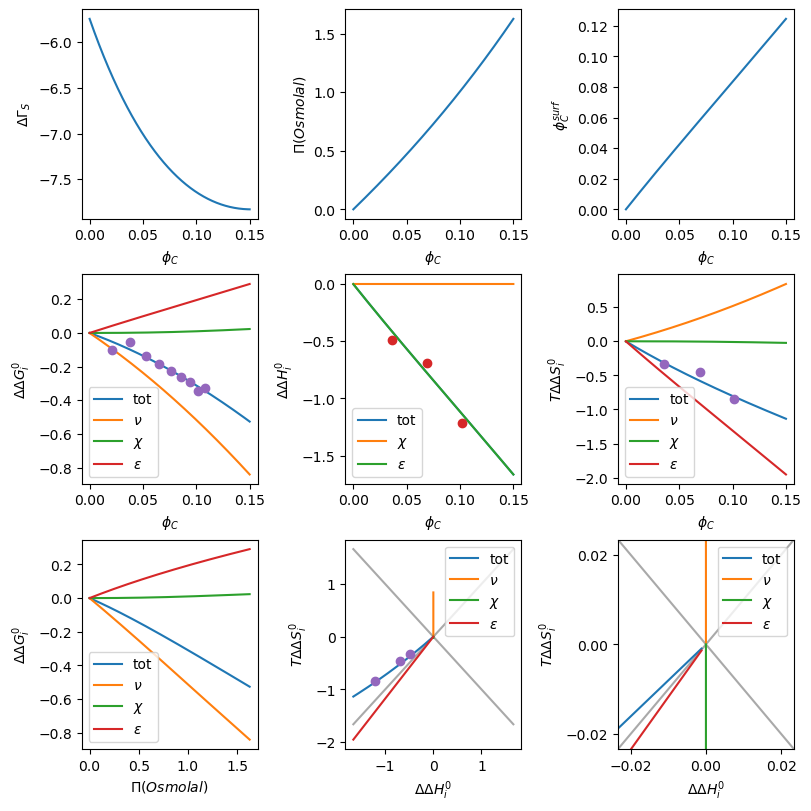

In [15]:
# 4. plot results of enthalpy and entropy fit 
AQ16_gluc.plot_results(exp_conc=phi,exp_ddG=ddG, exp_concT=phiT, exp_ddH=ddH, exp_TddS=TddS)

In [16]:
# Export results to a csv file
AQ16_gluc.to_pandas()
AQ16_gluc.results.to_csv('AQ16_gluc.csv',index=False)
AQ16_gluc.results.head()

,phiC,phiCsurf,phiS,phiSsurf,molar,molal,osm,gamma_per_vol,gamma,ddA_nu,...,ddA_chi_kJ,ddA_eps_kJ,ddA_kJ,ddE_chi_kJ,ddE_eps_kJ,ddE_kJ,TddS_nu_kJ,TddS_chi_kJ,TddS_eps_kJ,TddS_kJ
0,0.0001,0.000088,0.9999,0.999912,0.000886,0.000886,0.000886,-0.123999,-5.745367,-0.000174,...,5.595282e-09,0.000205,-0.000227,0.0,-0.001170,-0.001170,0.000432,-5.595282e-09,-0.001374,-0.000943
1,0.0002,0.000175,0.9998,0.999825,0.001772,0.001772,0.001773,-0.124071,-5.748713,-0.000348,...,2.240721e-08,0.000409,-0.000454,0.0,-0.002339,-0.002339,0.000863,-2.240721e-08,-0.002748,-0.001885
2,0.0003,0.000263,0.9997,0.999737,0.002658,0.002659,0.002659,-0.124143,-5.752056,-0.000523,...,5.047486e-08,0.000614,-0.000682,0.0,-0.003509,-0.003509,0.001295,-5.047486e-08,-0.004122,-0.002827
3,0.0004,0.000350,0.9996,0.999650,0.003544,0.003546,0.003546,-0.124216,-5.755394,-0.000697,...,8.983727e-08,0.000818,-0.000909,0.0,-0.004678,-0.004678,0.001727,-8.983727e-08,-0.005496,-0.003769
4,0.0005,0.000438,0.9995,0.999562,0.004430,0.004432,0.004433,-0.124288,-5.758729,-0.000872,...,1.405335e-07,0.001023,-0.001137,0.0,-0.005847,-0.005847,0.002160,-1.405335e-07,-0.006869,-0.004710


## Review - Short Example

To review the most important steps of using the model, we repeat the analysis for another protein-cosolute pair, MET16 in presence of the dissacaride Trehalose

In [17]:
# Intialize Cosolute, Protein, and Crowding objects
Tre = Cosol(11.7, 0.433, -1.12)
print(Tre)
print()

MET16 = Protein(419)
print(MET16)
print()

MET16_tre=crowding_model(MET16,Tre,0,0,phiC_min=0.001,phiC_max=0.231,dphiC=0.001)
print(MET16_tre)

Cosol (ν=11.7, χ=0.433, χₛ=-1.12)

Protein (SASA=419)

Mean-Field Model:
Soft_Interactions (ε=0, εₛ=0) 
Protein (SASA=419) 
Cosolute (ν=11.7, χ=0.433, χₛ=-1.12)


In [18]:
# Experimental data
phiG = [0.03348,0.06678,0.09797,0.12606,0.14801,0.16786,0.18373]
ddG = [-0.21341,-0.50203,-0.89785,-1.19804,-1.37944,-1.81451,-1.96279]

phiHS = [0.0778, 0.1123, 0.1443]
ddH = [-1.96502,-2.92226,-3.62634]
TddS = [-1.39532,-2.00146,-2.43908]

In [21]:
# fit to data
MET16_tre.fit_eps(phiG,ddG)
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print(MET16_tre)
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
MET16_tre.fit_epsTS(phiHS,ddH,TddS)
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print(MET16_tre)
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')


Optimization terminated successfully.
         Current function value: 0.019247
         Iterations: 1
         Function evaluations: 6
         Gradient evaluations: 3
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Mean-Field Model:
Soft_Interactions (ε=0.01636365095547389, εₛ=0.33854086372231923) 
Protein (SASA=419) 
Cosolute (ν=11.7, χ=0.433, χₛ=-1.12)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Optimization terminated successfully.
         Current function value: 0.078349
         Iterations: 1
         Function evaluations: 6
         Gradient evaluations: 3
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Mean-Field Model:
Soft_Interactions (ε=0.01636365095547389, εₛ=0.3385408570415983) 
Protein (SASA=419) 
Cosolute (ν=11.7, χ=0.433, χₛ=-1.12)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


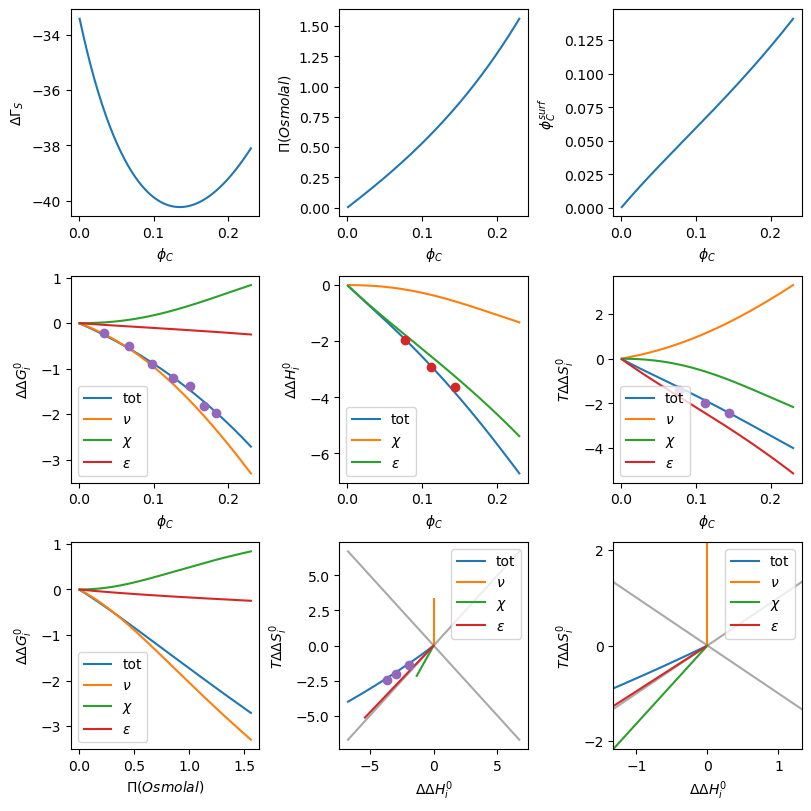

In [22]:
# plot results
MET16_tre.plot_results(exp_conc=phiG,exp_ddG=ddG, exp_concT=phiHS, exp_ddH=ddH, exp_TddS=TddS)
MET16_tre.results.to_csv('MET16_tre.csv',index=False)


##  Uncertainties in $\varepsilon$ and $\varepsilon_{TS}$

The estimation of uncertainties for $\varepsilon$ and $\varepsilon_{TS}$ is accomplished by subsampling following the Monte Carlo cross-validation method. In Monte Carlo cross-validation, the experimental data, which includes folding free energy, enthalpy, and entropy, is randomly sub-sampled to create a smaller dataset (that is two-thirds the size of the full dataset in our case). This sub-sampled data is used to derive estimates for the values of $\varepsilon$ and $\varepsilon_{TS}$. This entire process is iteratively repeated a specified number of times, denoted as "#iter," resulting in a collection of estimations for $\varepsilon$ and $\varepsilon_{TS}$ from which uncertainties can be computed.

In [23]:
def Uncertainty_Monte_Carlo_G(protein,cosol,phiG,ddG,iter=100,SRS=2/3):
    # iter -> number of Monte Carlo Iterations
    # SRS -> subset_relative_size
    
    phiG = np.array(phiG)
    ddG = np.array(ddG)
    protein_cosol = crowding_model(protein,cosol,0,-10,phiC_min=0.001,phiC_max=0.231,dphiC=0.001)
    
    eps=[]
    for k in range(iter):
        I = np.random.choice(int(len(phiG)),int(len(phiG)*SRS),replace=False)
        protein_cosol.fit_eps(phiG[I],ddG[I],disp=False)
        eps.append(protein_cosol.eps)
    eps=np.array(eps)
        
    return eps.mean(), eps.std()

def Uncertainty_Monte_Carlo_HS(protein,cosol,phiHS,ddH,TddS,eps,iter=6,SRS=2/3):

    phiHS = np.array(phiHS)
    ddH = np.array(ddH)
    TddS = np.array(TddS)
    
    protein_cosol = crowding_model(protein,cosol,eps,-10,phiC_min=0.001,phiC_max=0.231,dphiC=0.001)
    
    epsTS=[]
    for k in range(iter):
        I = np.random.choice(int(len(phiHS)),int(len(phiHS)*SRS),replace=False)
        protein_cosol.fit_epsTS(phiHS[I],ddH[I],TddS[I],disp=False)
        epsTS.append(protein_cosol.epsTS)
    epsTS=np.array(epsTS)
    return epsTS.mean(), epsTS.std()

In [24]:
eps_av, eps_sd = Uncertainty_Monte_Carlo_G(MET16,Tre,phiG,ddG)

In [25]:
print('eps = ', eps_av, '+-', eps_sd)

eps =  0.01625013360011266 +- 0.0026390513427927316


In [26]:
epsTS_av, epsTS_sd = Uncertainty_Monte_Carlo_HS(MET16,Tre,phiHS,ddH,TddS,eps_av)

In [27]:
print('epsTS = ', epsTS_av, '+-', epsTS_sd)

epsTS =  0.34228555390641 +- 0.008272517490778857
